# RNN Labb (endast G)

Ni ska skapa ett nätverk som kan klassificera känslor i text. Varje text består av en mening och har en känsla kopplad till sig. Datasetet som ska användas finns på ithsdistans. Koden ska skrivas i en jupyter notebook och den ska vara välstrukturerad och hålla god kod-kvalité. (T.ex. Använd väl valda variabelnamn och kommentarer där det behövs.)

## Frågor:

- **Motivera din modellarkitektur och val av relevanta hyperparametrar.**
- **Vilka aktiveringsfunktioner har du använt? Varför?**
- **Vilken loss funktion har du använt? Varför?**
- **Har du använt någon databehandling? Motivera dina val.**
- **Har du använt någon regulariseringsteknik? Motivera.**
- **Hur har modellen utvärderats?**
- **Är prestandan bra? Varför/ varför inte?**
- **Vad hade du kunnat göra för att förbättra den ytterligare?**
- **Generativ AI har blivit stort inom text. Beskriv skillnaden mellan generativ ai och mer traditionell ai.**

*Funderingar*:

- Ska jag göra någon data processing? Hur gör man det med RNN?

- **RNN/LSTM/LSTM-GRU, vilken väljer jag?**
    - RNN lider av vanishing gradient: svårt att lära sig beroenden över långa sekvenser
    - LSTM är en avancerad variant av RNN, designad för att inte stöta på vanishing gradient
    - LSTM-GRU: variant av RNN, liknande LSTM men med en enklare struktur.
- **VAL**:
    - **Enklare/Längre Sekvenser:** Grundläggande RNN
    - **Komplex/Längre Sekvenser:** LSTM eller GRU
    - **För Balans Mellan Prestanda & Komplexitet:** GRU, ofta enklare och snabbare att träna än LSTM, men har ändå relativt lika förmåner som LSTM.

Jag tänker att jag börjar med en grundläggande RNN, då datasetet verkar inte jätte komplext.


In [74]:
import pandas as pd
from loguru import logger
import tensorflow as tf
from statistics import mean, median
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv("emotions.csv")
pd.set_option('display.max_colwidth', None) # to be able to read entire text

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [76]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Create new column that has word count of each sentence

In [77]:
text_rows = df["text"]
sentence_length_characters = []

def character_counter_for_sentences():
    for row, text in enumerate(text_rows.iloc):
        sentence_length_characters.append(len(text))

character_counter_for_sentences()
df["character_amount"] = sentence_length_characters # add new column with character length

sentence_length_words = []

def word_counter_for_sentences():
    for row, text in enumerate(text_rows.iloc):
        sentence_length_words.append(len(text.split()))

word_counter_for_sentences()
df["word_amount"] = sentence_length_words # add new column with word length


print("---LENGTH OF SENTENCES IN DATASET (in characters)---")
print(f"Median Length Characters:", median(sentence_length_characters))
print(f"Average Length Characters:", mean(sentence_length_characters))
print(f"Smallest Length Characters:", min(sentence_length_characters))
print(f"Longest Length Characters:", max(sentence_length_characters))

print("\n---LENGTH OF SENTENCES IN DATASET (in words)---")
print(f"Median Length Words:", median(sentence_length_words))
print(f"Average Length Words:", mean(sentence_length_words))
print(f"Smallest Length Words:", min(sentence_length_words))
print(f"Longest Length Words:", max(sentence_length_words))

above_100_length = [length >= 100 for length in sentence_length_characters]
is_above_100 = above_100_length.count(True)
is_not_above_100 = above_100_length.count(False)

print(f"\nRows that are ABOVE or EQUAL to 100 characters long: {is_above_100}")
print(f"Rows that are BELOW 100 characters long: {is_not_above_100}")

print(f"\nExample sentence with 100 character length:\n", text_rows.iloc[9]) # manually looked for a sentence with 100 characters

above_10_words = [length >= 20 for length in sentence_length_words]
is_above_10 = above_10_words.count(True)
is_not_above_10 = above_10_words.count(False)

print(f"\nRows that are ABOVE or EQUAL to 20 words long: {is_above_10}")
print(f"Rows that are BELOW or EQUAL to 20 words long: {is_not_above_10}")

---LENGTH OF SENTENCES IN DATASET (in characters)---
Median Length Characters: 86.0
Average Length Characters: 96.67005
Smallest Length Characters: 7
Longest Length Characters: 300

---LENGTH OF SENTENCES IN DATASET (in words)---
Median Length Words: 17.0
Average Length Words: 19.13505
Smallest Length Words: 2
Longest Length Words: 66

Rows that are ABOVE or EQUAL to 100 characters long: 8099
Rows that are BELOW 100 characters long: 11901

Example sentence with 100 character length:
 i the ultimate place to restore the peace to feel divine to kneel for worship and to attain hapiness

Rows that are ABOVE or EQUAL to 20 words long: 8276
Rows that are BELOW or EQUAL to 20 words long: 11724


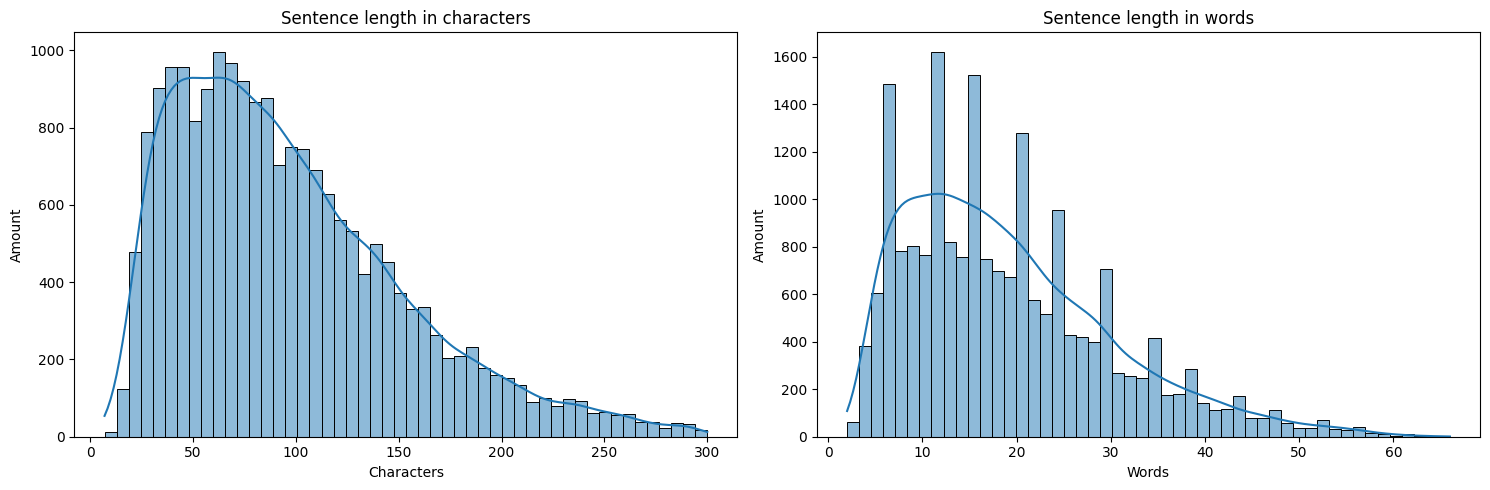

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['character_amount'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Sentence length in characters')
axs[0].set_xlabel('Characters')
axs[0].set_ylabel('Amount')

sns.histplot(df['word_amount'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Sentence length in words')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('Amount')

plt.tight_layout()
plt.show()

### Emotions distribution

In [79]:
emotions = df["label"].unique()
emotions_count = df["label"].value_counts()

for i in emotions:
    print(i)

print(f"\n{emotions_count}")

anger
sadness
joy
love
fear
surprise

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64


### add category encoding

In [80]:
df["emotion_label"] = df["label"].astype('category').cat.codes

for i in range(len(emotions)):
    print(f"{emotions[i]}: {i}")

anger: 0
sadness: 1
joy: 2
love: 3
fear: 4
surprise: 5


In [81]:
# train test validation split 80/10/10
X = df[['text']] # double brackets to keep it as a dataframe, otherwise shape is (n,) instead of (n, 1)
y = df[['emotion_label']]

# I don't see people split the data like this for alot of deep learning guides online. Why?
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}\n")

print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"y_val: {y_test.shape}")

X_train: (16000, 1)
X_test: (2000, 1)
X_val: (2000, 1)

y_train: (16000, 1)
y_test: (2000, 1)
y_val: (2000, 1)


### Removing stop words

In [82]:
nltk_stopwords = stopwords.words('english')
print(f"\nStopwords: {nltk_stopwords}")

def remove_stop_words(df): # loops every column for each row
    words = df.split() # only sentences - split makes each row list of words
    filtered_words = [word for word in words if word.lower() not in nltk_stopwords] # removes stopwords from list
    filtered_sentence = " ".join(filtered_words) # list -> string again
    return filtered_sentence

df["text"] = df["text"].apply(remove_stop_words) # each replaced with filtered sentence


Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [85]:
df

,text,label,character_amount,word_amount,emotion_label
0,feel pissed old friend friends,anger,56,12,0
1,ive found made huge difference especially finger ring skin feels much softer less irritated,anger,133,26,0
2,also feel unfortunate nearly readers going meet man african americans unlike,sadness,122,23,4
3,feel petty href http clairee,anger,32,7,0
4,used believe feeling like fear ignored suppressed right away moment,sadness,110,23,4
...,...,...,...,...,...
19995,might buying stuff feel clothes casual,joy,78,17,2
19996,like sonam deepika genelia feel talented beautiful,joy,75,14,2
19997,feel pathetic hardly go whole day talking,sadness,67,15,4
19998,id spent time reading feel bit guilty,sadness,74,16,4


# Model Creation